<a href="https://colab.research.google.com/github/rs89/parking_meter/blob/main/Parking_Meter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leave the Parking Meter Expired
>How much $ should I put in a parking meter?

Never the full-time. Let's get more precise.


When you weigh the decision of paying a parking meter, you are doing mental math to determine if and how much you should purchase.

> What if I'm just going to run in and be back in 5 minutes?

You don't pay the meter, and unless you're especially unlucky, a short stay rarely realizes a parking ticket. But it does happen!


In deciding how much time to purchase, your mental math is considering 4 factors:
1. How long you plan to stay
2. How often parking officers patrol the area
3. How much a parking ticket costs
4. How much it will cost to park

What I want to do is create a pricing model to calculate expected cost based the variables above. We will use this to find the **price point with the lowest expected cost**.

## Parking Officers

> If we knew exactly the next arrival time for a parking officer, we would consider purchasing enough time such that they pass an unexpired meter.

Sure, but we don't know it exactly. Instead, we have to model that uncertainty.

We model the next arrival time of a parking officer as a Poisson random process. In this case, we want to know the probability that the next officer's visit is within ```survival_time``` hours given the ```patrol_rate```.

In [1]:
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt

>What's the probability of getting a ticket within ```survival_time``` minutes given an interarrival rate of ```patrol_rate``` hours per visit?

In [4]:
patrol_rate = 1 # arrivals per hour
survival_time = 4 # time (in hrs)

# sf stands for 'survival function' which returns 1 - CDF
prob = poisson.sf(patrol_rate,survival_time)

print("The probability of a ticket at or before hour {} given the arrival rate of {} per hour is {:.1f}%.".format(survival_time,patrol_rate,prob*100))

The probability of a ticket at or before hour 4 given the arrival rate of 1 per hour is 90.8%.


### Why Poisson?

Poisson has 2 properties which make a good choice for interarrival times.
1. It's memoryless. The probability of an arrival in the next 5 minutes is the same regardless of what's happened in the past.
> so if a parking cop just showed up, we're estimating the same chances as if we waited for 5 hours and not one came by?

Yes.

2. The mean = variance. It's built-in.


## Parking Costs

We can always choose to purchase time from the parking meter.

## Creating the Pricing Model

What's the optimal value for ```purchased_time``` which minimizes expected loss?

The following function returns the expected cost *given* a value for `purchased_time`.

In [5]:
def get_expected_cost(stay, cop_rate, purchased_time, ticket_cost, parking_rate):
    '''
    Returns the expected cost of a parking strategy
    Inputs:
    stay - duration of your visit in hours
    cop_rate - Poisson arrival rate of parking cops
    purchased_time - how much time you purchase from the parking meter
    ticket_cost - how much a parking ticket costs
    parking_cost - how much it costs to park per hours
    '''

    # calculate expected cost from ticket
    unpaid_time = stay - purchased_time # assume stay >= purchased time
    prob_ticket = poisson.sf(cop_rate, unpaid_time)
    
    expected_ticket_cost = prob_ticket * ticket_cost

    # calculate (fixed) cost from parking
    parking_cost = purchased_time * parking_rate

    return expected_ticket_cost + parking_cost


 I'm sure there's a function to yield the minimum exactly... perhaps in a future version.

## Testing the pricing function
Let's validate the function with some intuition...

### Secnario 1: Paying the full amount


In [6]:
get_expected_cost(stay=3, cop_rate=1, purchased_time=3, ticket_cost=60, parking_rate=8)

24.0

If you pay the full amount of your stay, you have a 0% chance of getting a ticket. 

So your expected cost should be exactly = to `purchased_time` * `parking_rate` (which it is).

### Scenario 2: Paying nothing

In [7]:
get_expected_cost(stay=3, cop_rate=1, purchased_time=0, ticket_cost=60, parking_rate=8)

48.05110359171265

If you pay nothing to the meter, then the only expected cost can come from the parking ticket. So it's `ticket_cost` * the probability of a parking officer. 

Let's start with the probability of the parking officer -- what are the chances of an arrival within `stay` hours given a mean rate of `cop_rate`.

In [8]:
poisson.sf(1,3)

0.8008517265285442

About 80% chance she/he will show up.

In [9]:
 # assuming ticket cost is $60
 poisson.sf(1,3) * 60

48.05110359171265

Here we confirm that the expected result of not paying = cost of the ticket * probability of a parking officer arriving anytime during the `stay`.

## Finding the Lowest Cost Strategy

In lieu of a closed form solution, which I'm sure exists, I'm going to evaluate several levels of `purchased_time` between 0 and the total length of `stay`.

In [10]:
# Problem parameters
stay = 3 # time (in hrs) you plan on staying
cop_rate = 1 # arrival rate of parking police (one every x hours)
ticket_cost = 60 # dollars
parking_rate = 8 # dollars

In [11]:
# Create trials evenly spaced between 0 and length of stay
trials = np.linspace(0,stay,num=10000)

In [12]:
# Calculate the expected cost for each trial
results = [get_expected_cost(stay=stay, cop_rate=cop_rate, purchased_time=t, ticket_cost=ticket_cost, parking_rate=parking_rate) for t in trials]

In [13]:
# Convert to a numpy array from list so we can find minimums
results_arr = np.asarray(results)

In [14]:
# find the minimum
t_min = np.where(results_arr == results_arr.min())

In [15]:
# return the lowest price point
min_price = results_arr.min()

# return optimal purchase time
opt_time = trials[t_min[0][0]]

And the answer is...

In [16]:
print("You should purchase {:.2f} hours ({:.1f}% of your length of stay) for ${:.2f} and expect to pay ${:.2f}.".format(opt_time,(opt_time/stay)*100,parking_rate*opt_time,results_arr[t_min[0][0]]))

You should purchase 2.84 hours (94.8% of your length of stay) for $22.75 and expect to pay $23.41.


### Supporting Functions
We'll put the code above into functions so we can make scenarios easier later.

In [17]:
# Making a function for scenario testing later on
def get_price_array(trials, stay, cop_rate, ticket_cost, parking_rate):
  '''
  Return the array of optimal results given
  '''
  # Calculate the expected cost for each trial
  results = [get_expected_cost(stay=stay, cop_rate=cop_rate, purchased_time=t, ticket_cost=ticket_cost, parking_rate=parking_rate) for t in trials]

  # Convert to a numpy array from list so we can find minimums
  results_arr = np.asarray(results)

  return results_arr

In [18]:
def get_lowest_expected_cost(results_arr):
  '''
  Returns the lowest $ in the trials 
  '''
  return np.where(results_arr == results_arr.min())

In [19]:
def get_optimal_purchase_time(trials, opt_price):
  '''
  Returns the purchase time which yields the lowest $ in the trials
  '''
  return trials[opt_price]

### Visualizing the Price Curve

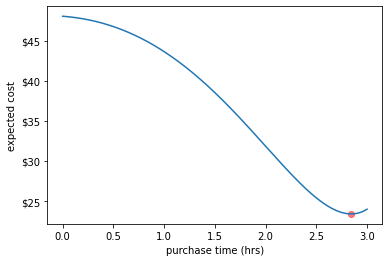

In [20]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

formatter = ticker.FormatStrFormatter('$%1.f')
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel('purchase time (hrs)')
ax.set_ylabel('expected cost')
ax.plot(trials, results)

ax.scatter(opt_time,min_price, color='r', alpha=0.5)
plt.show()

## Scenarios
Let's try out some scenarios and find the optimal price.

### Scenario 1: 1-hour visit
Here, we will look a reasonable parameters for a one hour visit 

In [21]:
# Problem parameters
stay = 1 # time (in hrs) you plan on staying
cop_rate = 2 # arrival rate of parking police (one every x hours)
ticket_cost = 60 # dollars
parking_rate = 8 # dollars per hour

#### Code

In [22]:
# Create trials
trials = np.linspace(0,stay,num=10000)

In [23]:
# Evaluate price model
results = get_price_array(trials=trials, stay=stay, 
                cop_rate=cop_rate, 
                ticket_cost=ticket_cost, 
                parking_rate=parking_rate)

In [24]:
# Find the lowest expected cost
opt_cost = get_lowest_expected_cost(results)

In [35]:
# Find the optimal purchase hours
t_min = np.where(results == results.min())

In [36]:
# return the lowest price point
min_price = results.min()

# return optimal purchase time
opt_time = trials[t_min[0][0]]

#### Answer:

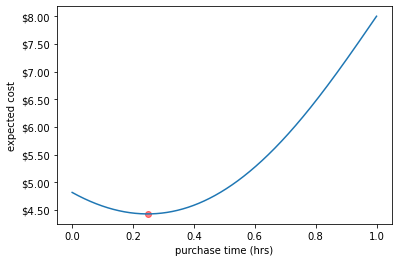

In [39]:
fig, ax = plt.subplots()

formatter = ticker.FormatStrFormatter('$%1.2f')
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel('purchase time (hrs)')
ax.set_ylabel('expected cost')
ax.plot(trials, results)

ax.scatter(opt_time, min_price, color='r', alpha=0.5)
plt.show()

In [40]:
print("You should purchase {:.2f} hours ({:.1f}% of your length of stay) for ${:.2f} and expect to pay ${:.2f}.".format(opt_time,(opt_time/stay)*100,parking_rate*opt_time,results[t_min[0][0]]))

You should purchase 0.25 hours (24.8% of your length of stay) for $1.98 and expect to pay $4.43.


### Scenario 2: Overnight Visit with Diligent Parking Officers
Think of this as going out one night, parking on the street and coming back 8 hours later to retrieve your car.

In [41]:
# Problem parameters
stay = 8 # time (in hrs) you plan on staying
cop_rate = 4 # arrival rate of parking police (one every x hours)
ticket_cost = 60 # dollars
parking_rate = 8 # dollars per hour

#### Code

In [42]:
# Create trials
trials = np.linspace(0,stay,num=10000)

In [43]:
# Evaluate price model
results = get_price_array(trials=trials, stay=stay, 
                cop_rate=cop_rate, 
                ticket_cost=ticket_cost, 
                parking_rate=parking_rate)

In [44]:
# Find the lowest expected cost
opt_cost = get_lowest_expected_cost(results)

In [45]:
# Find the optimal purchase hours
t_min = np.where(results == results.min())

In [46]:
# return the lowest price point
min_price = results.min()

# return optimal purchase time
opt_time = trials[t_min[0][0]]

#### Answer:

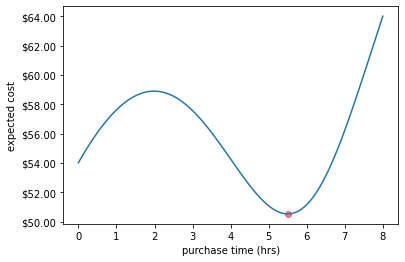

In [48]:
fig, ax = plt.subplots()

formatter = ticker.FormatStrFormatter('$%1.2f')
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel('purchase time (hrs)')
ax.set_ylabel('expected cost')
ax.plot(trials, results)

ax.scatter(opt_time, min_price, color='r', alpha=0.5)
plt.show()

In [49]:
print("You should purchase {:.2f} hours ({:.1f}% of your length of stay) for ${:.2f} and expect to pay ${:.2f}.".format(opt_time,(opt_time/stay)*100,parking_rate*opt_time,results[t_min[0][0]]))

You should purchase 5.50 hours (68.8% of your length of stay) for $44.02 and expect to pay $50.53.


What we notice here is that there's an inflection point around 2 hours -- up to this point, the chances are low that the officers will come by and you're probably good. But parking time begins to add up and at the lowest point, we've found the perfect balance. We NEVER would pay the full amount in this case because the `stay` * `parking_rate` > `ticket_cost`. 

### Scenario 3: Really Expensive Tickets & Very Diligent Parking Officers

Like parking at the CRC...


In [101]:
# Problem parameters
stay = 3 # time (in hrs) you plan on staying
cop_rate = 1 # arrival rate of parking police (one every x hours)
ticket_cost = 10000 # dollars
parking_rate = 8 # dollars per hour

#### Code

In [102]:
# Create trials
trials = np.linspace(0,stay,num=10000)

In [103]:
# Evaluate price model
results = get_price_array(trials=trials, stay=stay, 
                cop_rate=cop_rate, 
                ticket_cost=ticket_cost, 
                parking_rate=parking_rate)

In [104]:
# Find the lowest expected cost
opt_cost = get_lowest_expected_cost(results)

In [105]:
# Find the optimal purchase hours
t_min = np.where(results == results.min())

In [106]:
# return the lowest price point
min_price = results.min()

# return optimal purchase time
opt_time = trials[t_min[0][0]]

#### Answer:

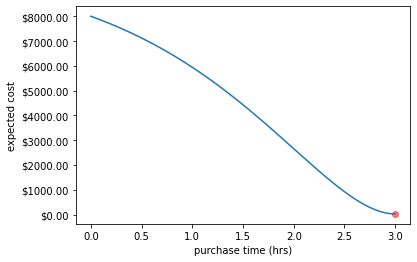

In [114]:
fig, ax = plt.subplots()

formatter = ticker.FormatStrFormatter('$%1.2f')
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel('purchase time (hrs)')
ax.set_ylabel('expected cost')
ax.plot(trials, results)

ax.scatter(opt_time, min_price, color='r', alpha=0.5)
plt.show()

In [113]:
plt.show()
print("You should purchase {:.6f} hours ({:.2f}% of your length of stay) for ${:.2f} and expect to pay ${:.2f}.".format(opt_time,(opt_time/stay)*100,parking_rate*opt_time,results[t_min[0][0]]))

You should purchase 2.999100 hours (99.97% of your length of stay) for $23.99 and expect to pay $24.00.


Even here, we shouldn't pay the full price. This makes sense because as `purchase_time` -> `stay`, the lower the chances we get a ticket. Even with a $10,000 ticket, it still makes sense to leave some time (albeit 3.24 seconds).

## Widget (coming soon)

In [ ]:
%matplotlib notebook
%matplotlib inline
# Interactive widget
w_stay = IntSlider()
display(w_stay)

#@widgets.interact(w_stay)
def update():
  results = [get_expected_cost(stay=w_stay.value, 
                               cop_rate=cop_rate, 
                               purchased_time=t, 
                               ticket_cost=ticket_cost, 
                               parking_rate=parking_rate) for t in trials]
  [l.remove() for l in ax.lines]
  ax.plot(trials, results)
  plt.show()
  print("success")

w_stay.observe(update)

In [38]:
w_stay = FloatSlider(
    value=3,
    min=0,
    max=24,
    step=0.1,
    description='Length of stay (hrs):',
    disabled=False,
    continuous_update=False,
    readout_format='.1f',
)

In [39]:
w_stay

FloatSlider(value=3.0, continuous_update=False, description='Length of stay (hrs):', max=24.0, readout_format=…